<h1>California Housing Data Project</h1>

<h2> A "Hands-On Machine Learning with Scikit-Learn and TensorFlow" Project </h2>

<p>In this project/task I am practicing some basic concepts from the second chapter of "Hands-On Machine Learning with Scikit-Learn and TensorFlow" that go over working with Pandas, Matplotlib, NumPy and Scikit-Learn (Géron, 2017).</p>

<p>The dataset that is being used for this project is one from the StarLib repository, containing information about California Housing Prices based on data from the 1990 California consensus (Pace & Barry, 1997).</p>

***

<h2> References </h2>

<ul>
    <li>Pace, R.K., Barry, R. (1997). “Sparse Spatial Autoregressions,” Statistics & Probability Letters 33, no. 3 (1997): 291–297.</li>
    <li>
        Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow.</li>
   
</ul>



In [1]:
import os
import pandas as pd
import numpy as np

# 1. Getting the dataset

> First we need to get the data which is stored on GitHub. For which we will write a function that downloads the dataset file (.tgz)and extracts it in a CSV format in the `./dataset/housing` folder.

In [2]:
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_housing_data(housing_url= HOUSING_URL, housing_path= HOUSING_PATH):
    """
    Requires a the data origin path (housing_url) and the data destination path (housing_path).
    
    1. Checks if the housing_path exists under our root dir. If not, creates it.
    2. Downloads the dataset (which is in .tgz format) to the root/housing_path.
    3. Extracts all files from the dataset to the root/housing_path folder.
    
    """
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()


fetch_housing_data()

## <li> Loading the dataset in a pd.DataFrame() and initial overview of the data </li>

> We will write a function that loads the data into a `pd.DataFrame()`.

In [3]:
def load_housing_data(housing_path= HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

housing = load_housing_data()

> An initial view of our data.

In [4]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


> The `info()` method is useful to get a quick description of the data. It shows the total number of rows containing non-null values and each attribute's type.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


> `ocean_proximity` is the only attribute of type `<object>` and since it has been loaded from a CSV file it is safe to assume it is a text attribute.


In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Another quick overview of the data is to plot a histogram for each numerical attribute

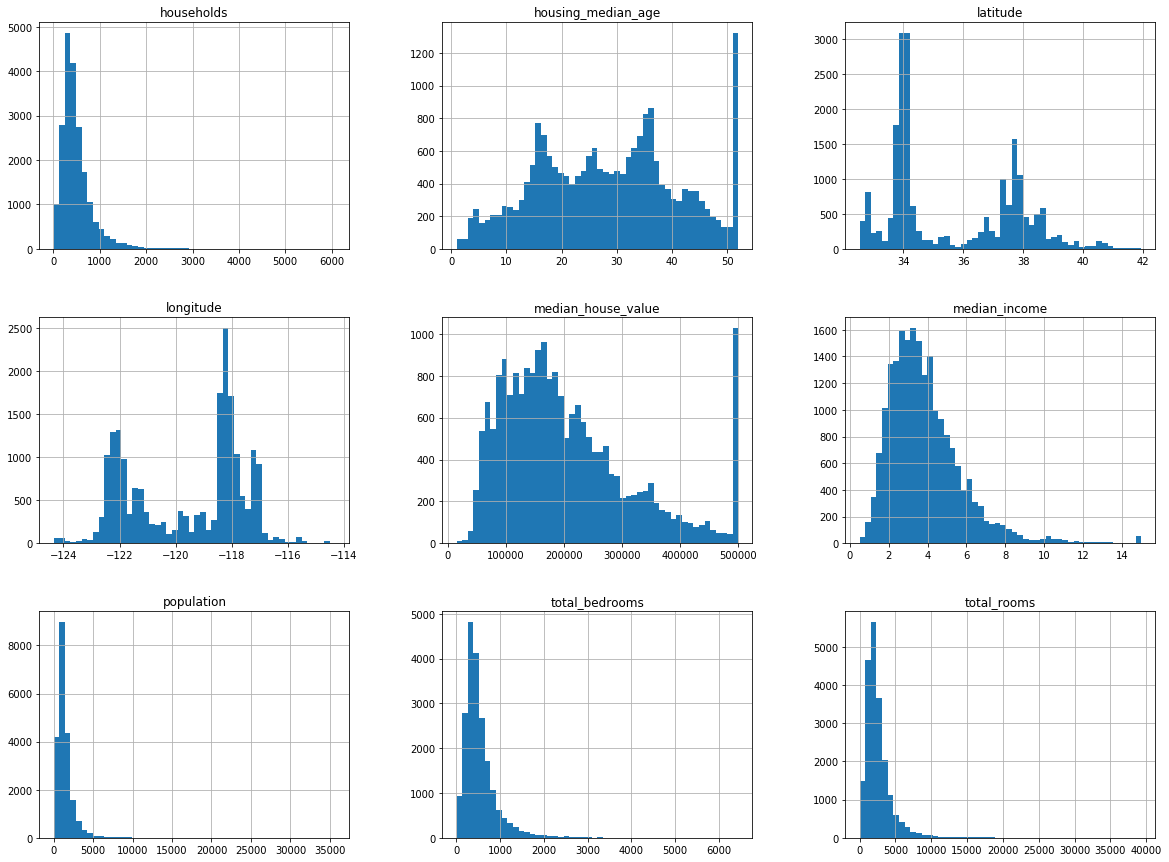

In [7]:
%matplotlib inline 

# important to have the plots generated here in Jupyter

import matplotlib.pyplot as plt

housing.hist(bins= 50, figsize= (20, 15)) # Figsize accepts a (height, length) tuple
plt.show() 

# If you don't write this line, you will get all of the additional info about the plot objects (memory space and etc.)

We can observer several things in these histograms:
<ol>
    <li> The median income attribute does not look like it is expressed in US dollars (USD). It is actually scaled and capped at 15 for higher median incomes and 0.5 for lower median incomes.
    </li> <br>
    <li> The housing median age and median house value are also capped. Since median house value is the target attribute it may be a serious problem for the ML algorithm - they may learn that prices do not go over the cap ($500,000). <br><br> This can be fixed by either: <br>
    <ul>
        <li> 
        Collecting the real values for the districts with capped attribues.
        </li>
        <li> 
        Removing these districts from the dataset.
        </li>
        </ul>
    </li><br>
    <li>
    The attributes have very different scales. We need to explore feature  scaling.
    </li><br>
    <li>
    The histograms are <i>tail heavy</i>: they are skewed to the right and we will try transforming those attribues to a more bell-shaped distributions.
    </li>
</ol>

# 2. Creating a Test Set 

> We need to set aside 20% of the data for testing purposes. For that purpose we will use `train_test_split` from `sklearn.model_selection`

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, 
                                       test_size= 0.2,
                                       random_state= 42)
print('Train set:', len(train_set), "+ Test set:", len(test_set))

Train set: 16512 + Test set: 4128


> People often set the random seed/ random_state to 42, for no other reason than - 42 is the Answer of the Ultimate Question of Life, the Universe, and Everything.

## A need for Stratified Sampling
 What we had done above is a random sampling methodology, which is generally fine if the dataset is large enough, however, if that isn't the case, there is a risk of introducing a sampling bias. Since, it could be hypothesized that the `median income` is a very important attribute to predict our target `median housing prices`, we can perform a **stratified sampling** based on `median income` and split our test and training sets accordingly. 
 
Since the `median income` is a continuous numerical attribute, we need to create an income category attribute.

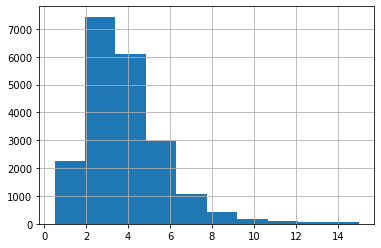

In [9]:
housing['median_income'].hist()
plt.show()

> It seems that most of the values are clustured around the range 2-5, however there are still values well beyond 6. To ensure that there are enough instances in each of our categories, we will merge all categories beyond 5 into category 5. We will create an income category attribute by dividing the median income by 1.5 and rounding up using `np.ceil` (to have discreet categories).

In [10]:
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)

> `np.ceil()` is used to round up a float to its "ceil".

> `np.floor()` does the opposite.


In [11]:
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace= True)

> To split the dataset into **train_set** and **test_set** we will use `StratifiedShuffleSplit` from `sklearn.model_selection`.

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1,
                              test_size = 0.2,
                              random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

> Now to remove the `income_cat` attribute so the data is back to normal.

In [13]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis= 1,inplace= True)
    
for column in strat_train_set.columns:
    print(column)

longitude
latitude
housing_median_age
total_rooms
total_bedrooms
population
households
median_income
median_house_value
ocean_proximity


> **\*Note** - Many methods in Pandas have the parameter `inplace=`. This will complete the operation without you having to reassign the dataframe. 

# 3. Exploratory Data Analysis Through Visualizations

> It is good to first create a copy of the `strat_train_set` by using the `.copy()` method on it, so that we can have the original on the side just in case. 

In [14]:
housing = strat_train_set.copy()

## Geographical Data with Matplolib

Since we have the attributes `latitude` and `longitude` we can plot them on a scatterplot to visualize the data.

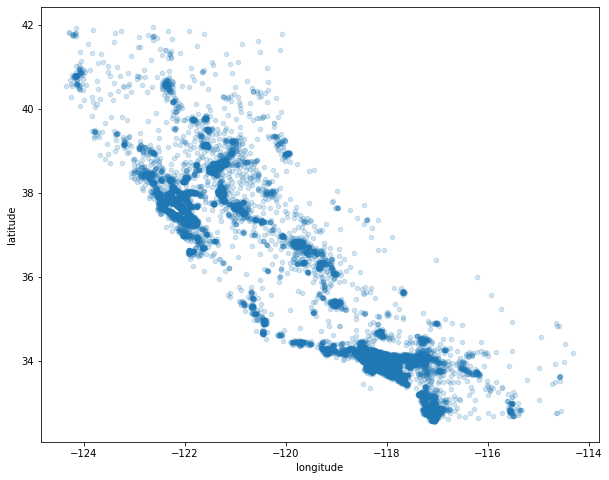

In [15]:
housing.plot(kind = 'scatter',
             x = 'longitude',
             y = 'latitude',
             alpha = 0.2,
             figsize = (10, 8))
plt.show()

> The `figsize=` parameter accepts tuples with height x length values for the figure size.

> `alpha=` controls the opacity of each dot on the scatterplot. In this case, lowering it makes it easier to see places with higher density. 

## Housing Prices and District Population Size

> `s=` represents the radius of each circle/dot, which we have selected to be the `population`. We are dividing it by 100, otherwise the dots will be too big.

> `c=` represents color, or in our case the `median_house_value`

> `cmap= plt.get_cmap('jet')` is a predefined color map called `jet`, which ranges from blue (low values) to red (high values)

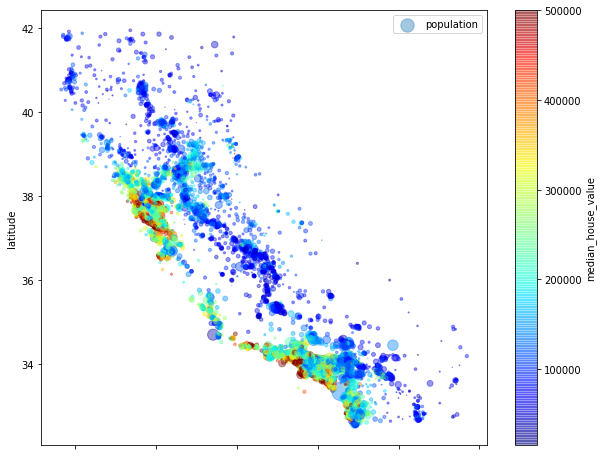

In [16]:
housing.plot(
            kind = 'scatter',
            x = 'longitude',
            y = 'latitude',
            alpha = 0.4,
            s = housing['population'] / 100,
            label = 'population',
            c = "median_house_value",
            cmap = plt.get_cmap('jet'),
            colorbar = True,
            figsize = (10, 8)
            )

plt.show()